In [54]:
"""Much of this code from the excellent https://github.com/higgsfield/RL-Adventure"""
import math, random
import gym
from gym import spaces, logger
from gym.utils import seeding
import numpy as np

import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.autograd as autograd 
import torch.nn.functional as F

import time
import os

import seaborn as sns


import sys
if "../../" not in sys.path:
  sys.path.append("../../") 

torch.manual_seed(0)
np.random.seed(0)

import collections
import torch.nn as nn

from  collections  import deque
%matplotlib inline

from IPython.display import clear_output

USE_CUDA = torch.cuda.is_available()
USE_CUDA = False
Variable = lambda *args, **kwargs: autograd.Variable(*args, **kwargs).cuda() if USE_CUDA else autograd.Variable(*args, **kwargs)


In [55]:
def save_model(model_name, net, optimizer):

    # Print model's state_dict
    print("Model's state_dict:")
    for param_tensor in net.state_dict():
        print(param_tensor, "\t", net.state_dict()[param_tensor].size())

    # Print optimizer's state_dict
    print("Optimizer's state_dict:")
    for var_name in optimizer.state_dict():
        print(var_name, "\t", optimizer.state_dict()[var_name])

    save_path = os.path.join(os.getcwd(), "models", model_name.split(",")[0])
    torch.save(net.state_dict(), save_path)

    with open(save_path + "_information.txt", "a") as f:
        for l in model_name.split(","):
            f.write(l + "\n")


def load_model(net, path):
    net.load_state_dict(torch.load(path))
    net.eval()

In [56]:
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state      = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)
            
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done
    
    def __len__(self):
        return len(self.buffer)

In [57]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. 
                                                                * frame_idx / epsilon_decay)

In [58]:
class Market(gym.Env):
    def __init__(self, kappa, episodes, time_periods, mu, r, sigma, inv_range):

        self.episodes = episodes
        self.time_periods = time_periods
        self.epi = 0
        self.t = 0

        self.inv_range = inv_range

        self.mu = mu
        self.r = r
        self.sigma = sigma

        self._start_wealth = 100.0
        self.kappa = kappa

        self.action_space = spaces.Discrete(len(inv_range))
        self.observation_space = spaces.Box(0,120, np.array([2]))
        
        self.seed()
        self.viewer = None
        self.state = None

        
    def seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]
    
    def reset(self):
        self.S, self.B, self.dS, self.dB = self.generate_price_series()
        self.wealth = self._start_wealth
        #self.state = (int(self.S[self.t,self.epi]*100),int(self._start_wealth/10))
        
        self.state = (self.S[self.t,self.epi],self._start_wealth)
        return np.array(self.state)

    
    def step(self, action):
        
        assert self.action_space.contains(action), "%r (%s) invalid"%(action, type(action))
        price_state, wealth_state = self.state
        
        prop = self.inv_range[action]

        discount = 0.99

        if self.t < self.time_periods:
            NB = (1-prop)*self.wealth/self.B[self.t]
            NS = prop*self.wealth/self.S[self.t, self.epi]

            dX = NB*self.dB[self.t] +NS*self.dS[self.t,self.epi]
            reward = dX - (self.kappa/2)*(dX**2)  
            self.wealth += dX

            done = False

            #self.wealth_state = int(self.wealth/10)
            self.wealth_state = self.wealth
            self.t += 1
            
            #new_state = (int(self.S[self.t,self.epi]*100), self.wealth_state)
            new_state = (self.S[self.t,self.epi], self.wealth_state)
            self.state = new_state
            final_wealth = 0.0
            
        else:
            #reached the end of episode...
            self.t = 0
            self.epi = 0 #+=1

            reward = 0.0
            dX = 0.0
            final_wealth = self.wealth
            done = True

            _ = self.reset()

        return np.array(self.state), reward, done, final_wealth

    def generate_price_series(self):
        I = 1 #self.episodes
        M = self.time_periods

        S0 = 1
        B0 = 1
        T = 1.0
        dt = T/M

        mu = self.mu
        r = self.r
        sigma = self.sigma

        S = np.zeros((M+1,I))
        dS = np.zeros((M,I))
        dB = np.zeros(M)

        B = np.zeros(M+1)
        B[0] = B0
        S[0] = S0

        for t in range(1, M+1):
            z = np.random.standard_normal(I)
            #df = 10
            #z = np.random.standard_t(df,I)
            S[t] = S[t-1]*np.exp((mu-0.5*sigma**2)*dt + sigma*math.sqrt(dt)*z)
            B[t] = B[t-1]*np.exp(r*dt)

        for t in range(1,M):
            dS[t] = S[t+1] - S[t]
            dB[t] = B[t+1] - B[t]

        # print(f"{S=}")
        # print(f"{B=}")
        # print(f"{dS=}")
        # print(f"{dB=}")
        return S, B, dS, dB

In [59]:
kappa = 0.008
episodes = 3000000
time_periods = 20
mu =0.10
rf = 0.02
sigma = 0.20

In [60]:
episodes = episodes #500k worked well? as did 1m

utes = 15
u_star = np.linspace(0,5, utes)

Mark = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star) #parameters from earlier

In [61]:
env = Mark

for _ in range(1):
    for i in range(1):
        if i == 0:
            states = env.reset()
        else:
            states, rewards, dones, info = env.step(actions)

        # actions = np.random.uniform(low=0, high=1, size=(n_paths,))
        actions = np.ones((1,)) * 1.2

In [62]:
class DQN(nn.Module):
    def __init__(self, num_inputs, num_actions):
        super(DQN, self).__init__()
        
        self.layers = nn.Sequential(
            nn.Linear(env.observation_space.shape[0], 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, env.action_space.n)
        )
        
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state   = Variable(torch.FloatTensor(state).unsqueeze(0), volatile=True)
            q_value = self.forward(state)
            action  = q_value.max(1)[1].data[0].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [63]:
model = DQN(env.observation_space.shape[0], env.action_space.n)

if USE_CUDA:
    model = model.cuda()
    
optimizer = optim.Adam(model.parameters())

replay_buffer = ReplayBuffer(1000)

In [64]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)
    

    state      = Variable(torch.FloatTensor(np.float32(state)))
    next_state = Variable(torch.FloatTensor(np.float32(next_state)), volatile=True)
    action     = Variable(torch.LongTensor(action))
    reward     = Variable(torch.FloatTensor(reward))
    done       = Variable(torch.FloatTensor(done))

    
    q_values      = model(state)
    next_q_values = model(next_state)

    q_value          = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value     = next_q_values.max(1)[0]
    expected_q_value = reward + gamma * next_q_value * (1 - done)
    
    loss = (q_value - Variable(expected_q_value.data)).pow(2).mean()
        
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    return loss

In [65]:
def plot(frame_idx, rewards, losses):
    clear_output(True)
    plt.figure(figsize=(20,5))
    plt.subplot(131)
    plt.title('frame %s. reward: %s' % (frame_idx, np.mean(rewards[-10:])))
    plt.plot(rewards)
    plt.subplot(132)
    plt.title('loss')
    plt.plot(losses)
    plt.show()

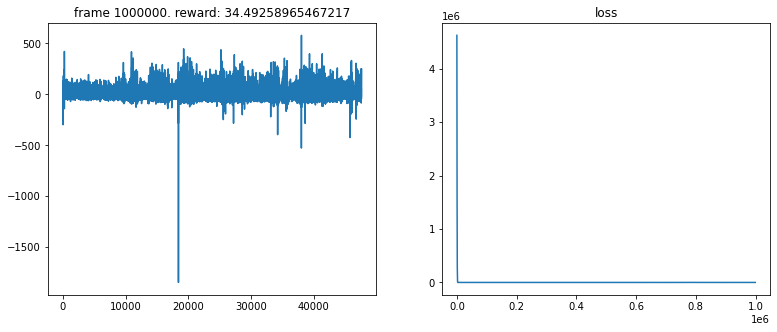

Model's state_dict:
layers.0.weight 	 torch.Size([128, 2])
layers.0.bias 	 torch.Size([128])
layers.2.weight 	 torch.Size([128, 128])
layers.2.bias 	 torch.Size([128])
layers.4.weight 	 torch.Size([15, 128])
layers.4.bias 	 torch.Size([15])
Optimizer's state_dict:
state 	 {0: {'step': 1000968, 'exp_avg': tensor([[ 5.6052e-45,  5.6052e-45],
        [ 0.0000e+00,  0.0000e+00],
        [ 5.6052e-45,  5.6052e-45],
        [ 5.6052e-45,  5.6052e-45],
        [ 5.6052e-45,  5.6052e-45],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 5.6052e-45,  5.6052e-45],
        [ 5.6052e-45,  5.6052e-45],
        [ 0.0000e+00,  0.0000e+00],
        [ 5.6052e-45,  5.6052e-45],
        [-5.6052e-45, -5.6052e-45],
        [ 5.6052e-45,  5.6052e-45],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [-5.6052e-45, -5.6052e-45],
        [ 0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00],
        [ 5.6052e-45,  5.6052e-45],
        [ 

In [67]:
num_frames = 1000000
# num_frames = 1000
batch_size = 32
gamma      = 0.99

MODEL_NAME = str(
    f"model-{int(time.time())}")
    
losses = []
all_rewards = []
episode_reward = 0

state = env.reset()

for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx)
    
    action = model.act(state, epsilon) #norm
    #print(action)
    
    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)
    
    state = next_state
    episode_reward += reward
    
    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
        
    if len(replay_buffer) > batch_size:
        #print('here')
        loss = compute_td_loss(batch_size)
        # losses.append(loss.data[0])
        losses.append(loss.data)
        
    if frame_idx % 400 == 0:
        plot(frame_idx, all_rewards
                         ,np.convolve(losses,np.ones((1000,))/1000,mode='valid'))
        
        #plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
        #plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
        #plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')

save_model(MODEL_NAME, model, optimizer)

In [41]:
episodes = 100001
wealth = 100.0
utilities_mod = []
rewards_mod = []
step_rewards = []
rsum = 0
wealth_episodes = []
number_of_actions = utes

Mark1 = Market(kappa, episodes, time_periods, mu, rf, sigma, u_star)


for i_episode in range(episodes-1):

    if i_episode%10000 ==0:
        print(i_episode)
        
    state = Mark1.reset() 
    action = model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

    while True:    
        new_state , reward, done, final_wealth = Mark.step(action) #(prop, wealth))
        action = model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
        rsum += reward
        state = new_state

        #print(new_state)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        step_rewards.append(reward)

        if done:
            wealth_episodes.append(final_wealth)
            utilities_mod.append(np.log(final_wealth))
            rewards_mod.append(rsum)
            rsum = 0
            #wealth = 100.0
            #print(i_episode, final_wealth)
            break 


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0
10000
20000
30000
40000
50000
60000
70000
80000
90000


In [42]:
utilities_test = utilities_mod
rewards_test = rewards_mod
step_rew_test = step_rewards
wealth_test = wealth_episodes

In [43]:
from lib.sim_prices import make_prices
from lib.execute_strat import execute_strat
from lib.graphs import make_baseline_graphs, make_agent_graphs, plot_sample_paths, plot_disc_utility, \
                        plot_mv_equiv, plot_const_step

In [44]:
#episodes = 99##3000000
#Q, utilities_mod, rewards_mod, wealth_episodes = train_agent(kappa, episodes)

def make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                      utilities_test_best, utilities_test_rand, utilities_test,
                     wealth_test_rand, wealth_test_best, wealth_test):

    block_utilities_test = np.mean(np.array(utilities_test).reshape(1000,-1),0)
    block_utilities_test_rand = np.mean(np.array(utilities_test_rand).reshape(1000,-1),0)
    block_utilities_test_best = np.mean(np.array(utilities_test_best).reshape(1000,-1),0)


    block_wealth_test_rand = np.mean(np.array(wealth_test_rand).reshape(1000,-1),0)
    block_wealth_test_best = np.mean(np.array(wealth_test_best).reshape(1000,-1),0)
    block_wealth_test = np.mean(np.array(wealth_test).reshape(1000,-1),0)


    block_rewards_test = np.mean(np.array(rewards_test).reshape(1000,-1),0)
    block_rewards_test_rand = np.mean(np.array(rewards_test_rand).reshape(1000,-1),0)
    block_rewards_test_best = np.mean(np.array(rewards_test_best).reshape(1000,-1),0)

    #Calculate sharpe ratios instead of longitudinally do it at the end blocks of 1000 again

    #mu - rf/ sigma
    wr = np.array(wealth_test_rand).reshape(100,-1)
    wr_sharpe = (wr.mean(axis=0)/100-1)/(wr.std(axis=0)/100)

    wt = np.array(wealth_test).reshape(100,-1)
    wt_sharpe = (wt.mean(axis=0)/100-1)/(wt.std(axis=0)/100)

    wb = np.array(wealth_test_best).reshape(100,-1)
    wb_sharpe = (wb.mean(axis=0)/100-1)/(wb.std(axis=0)/100)


    sns.distplot(block_rewards_test_best, label="Merton optimal")
    sns.distplot(block_rewards_test, label="Trained Agent")
    sns.distplot(block_rewards_test_rand, label="Random agent")
    plt.title('Distribution of Final rewards Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Rewards')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_rewards_test_rand, block_rewards_test, block_rewards_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Rewards", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Rewards - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_utilities_test_best, label="Merton optimal")
    sns.distplot(block_utilities_test, label="Trained Agent")
    sns.distplot(block_utilities_test_rand, label="Random agent")
    plt.title('Distribution of Final Utilities Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Utilities')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([block_utilities_test_rand, block_utilities_test, block_utilities_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Utility", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of utilities - Random v Merton v Agent")
    plt.show()

    plt.plot(np.convolve(utilities_test_best, np.ones((10000,))/10000, mode='valid'), label='Merton Optimal')
    plt.plot(np.convolve(utilities_test_rand, np.ones((10000,))/10000, mode='valid'), label='Random agent')
    plt.plot(np.convolve(utilities_test, np.ones((10000,))/10000, mode='valid'), label='Trained agent')
    plt.title('Moving average 10,000 episode utilities')
    plt.ylabel('Utility')
    plt.xlabel('Episode')
    plt.legend()
    plt.show()

    plt.violinplot([block_wealth_test_rand, block_wealth_test, block_wealth_test_best])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Wealth", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Wealth - Random v Merton v Agent")
    plt.show()


    sns.distplot(block_wealth_test_best, label="Merton optimal")
    sns.distplot(block_wealth_test, label="Trained Agent")
    sns.distplot(block_wealth_test_rand, label="Random agent")
    plt.title('Distribution of Final Wealth Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Wealth')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    plt.violinplot([wr_sharpe, wt_sharpe, wb_sharpe])
    plt.xticks([1,2,3], ["Random Agent", "Trained Agent", "Merton Optimal"], rotation=60, size=12)
    plt.ylabel("Test Sharpe", size=12)
    plt.xlabel("Agent", size=12)
    ax = plt.gca()
    ax.set_axis_bgcolor('white')
    ax.grid(0)
    plt.title("Violin plot of Sharpe ratios (M period) - Random v Merton v Agent")
    plt.show()

    sns.distplot(wb_sharpe, label="Merton optimal")
    sns.distplot(wt_sharpe, label="Trained Agent")
    sns.distplot(wr_sharpe, label="Random agent")
    plt.title('Distribution of Final Sharpe ratios  Merton v Trained Agent v Random (per 1000 episodes)')
    plt.xlabel('Episode Sharpe')
    plt.ylabel('Frequency')
    plt.legend()
    plt.show()

    return block_utilities_test_rand, block_utilities_test, block_utilities_test_best, \
           block_rewards_test_rand, block_rewards_test, block_rewards_test_best, \
           block_wealth_test_rand, block_wealth_test, block_wealth_test_best, \
           wr_sharpe, wt_sharpe, wb_sharpe

In [45]:
wealth = 100.0

merton_ratio = (mu-rf)/sigma**2
best_action = np.argmin(np.abs(u_star-merton_ratio))
#temp change to execute strat
utilities_test_rand, rewards_test_rand, step_rew_rand, wealth_test_rand = execute_strat(kappa,mu, 
                                                                      rf, sigma, utes,u_star,best_action, 'Random',
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)
utilities_test_best, rewards_test_best, step_rew_best, wealth_test_best = execute_strat(kappa, mu, rf, sigma, 
                                                                      utes, u_star, best_action,'Merton', 
                                                                      episodes=100001,
                                                                      time_periods=time_periods, wealth=wealth)

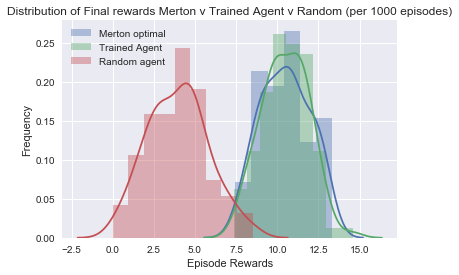

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:49: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


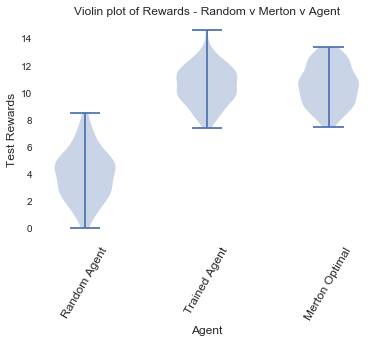

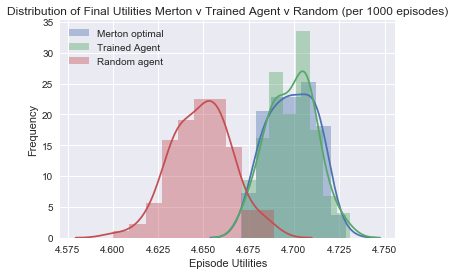

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:69: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


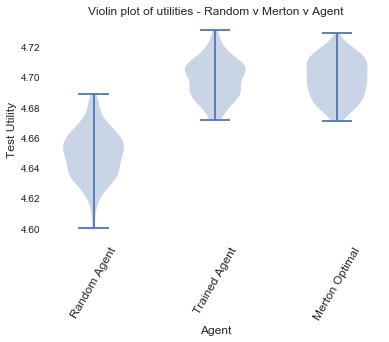

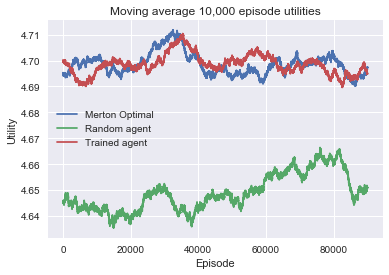

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:88: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


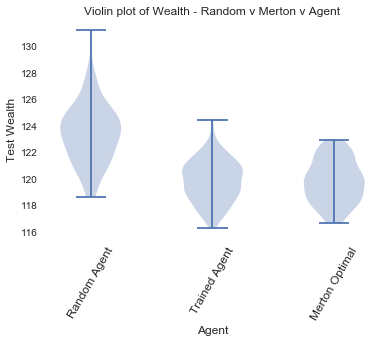

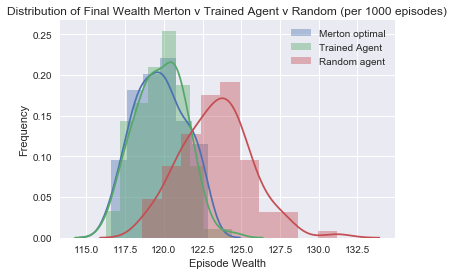

/Users/johngoodacre/anaconda/envs/pytorch/lib/python3.6/site-packages/ipykernel_launcher.py:108: MatplotlibDeprecationWarning: The set_axis_bgcolor function was deprecated in version 2.0. Use set_facecolor instead.


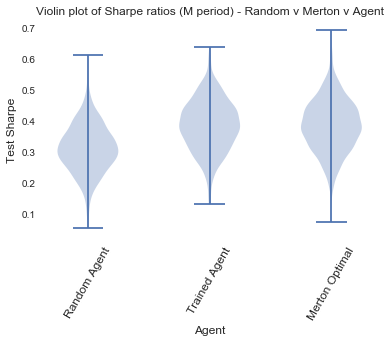

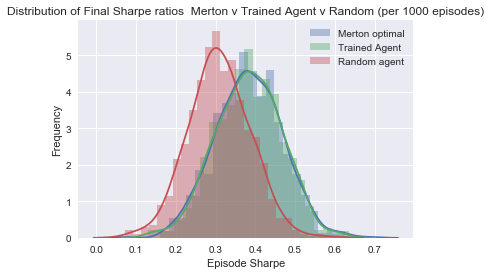

In [46]:
#utilities_test, rewards_test, step_rew_test, wealth_test = execute_strat(kappa, mu, rf, sigma, utes, u_star,best_action, 
#                                                            'Agent', q_values=Q, 
#                                                            time_periods=time_periods, wealth=wealth)

results = make_agent_graphs_new(rewards_test_best, rewards_test_rand, rewards_test,
                  utilities_test_best, utilities_test_rand, utilities_test,
                         wealth_test_rand, wealth_test_best, wealth_test)

In [47]:
for r in results:
    print(np.mean(r))

4.648910868039739
4.698714400983782
4.6987540983223
3.957626339721907
10.49922155925723
10.493630569356531
123.36834964248281
119.77257810824398
119.74807342228542
0.30980748633664634
0.3831496341981187
0.3837782093203221


In [48]:
for r in results:
    print(np.std(r))

0.016385984467360684
0.013013503294523717
0.013255459031532833
1.8240680435014167
1.4019249182296356
1.4837798424665614
2.2410487046868277
1.5692730678262694
1.6197137043232774
0.07819374990426393
0.0833678517946322
0.083853755480452


In [64]:
#looking at actions

episodes_act = 10001
#wealth_act = 100.0
#utilities_mod_act = []
#rewards_mod_act = []
#step_rewards_act = []
#rsum_act = 0
#wealth_episodes_act = []
#number_of_actions_act = utes

Mark1_act = Market(kappa, episodes_act, time_periods, mu, rf, sigma, u_star)

action_list = []

for i_episode in range(episodes_act-1):

    if i_episode%10000 ==0:
        print(i_episode)
        
    state = Mark1_act.reset() 
    action = model(Variable(torch.FloatTensor(np.float32(state)))).argmax().item()

    while True:    
        new_state , reward, done, final_wealth = Mark.step(action) #(prop, wealth))
        action = model(Variable(torch.FloatTensor(np.float32(new_state)))).argmax().item()
        action_list.append(action)
        
        #print(state,action)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        
        
        #rsum_act += reward
        state = new_state

        #print(new_state)
        #print(model(Variable(torch.FloatTensor(np.float32(new_state)))))
        #step_rewards_act.append(reward)

        if done:
            #wealth_episodes_act.append(final_wealth)
            #utilities_mod_act.append(np.log(final_wealth))
            #rewards_mod_act.append(rsum)
            #rsum_act = 0
            #wealth = 100.0
            #print(i_episode, final_wealth)
            break 

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
0


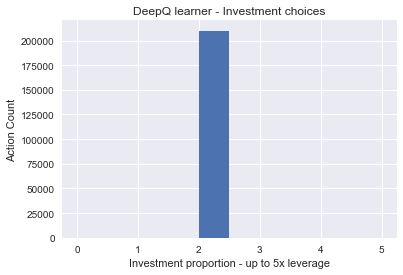

In [71]:
plt.hist(u_star[action_list], range=(0,5))
plt.title('DeepQ learner - Investment choices')
plt.xlabel('Investment proportion - up to 5x leverage')
plt.ylabel('Action Count')

In [55]:
u_star[6]

2.142857142857143

In [61]:
#helper function to give keras like model summary
import torch
import torch.nn as nn
from torch.autograd import Variable

from collections import OrderedDict


def summary(model, input_size, device="cuda"):
        def register_hook(module):
            def hook(module, input, output):
                class_name = str(module.__class__).split('.')[-1].split("'")[0]
                module_idx = len(summary)

                m_key = '%s-%i' % (class_name, module_idx+1)
                summary[m_key] = OrderedDict()
                summary[m_key]['input_shape'] = list(input[0].size())
                summary[m_key]['input_shape'][0] = -1
                if isinstance(output, (list,tuple)):
                    summary[m_key]['output_shape'] = [[-1] + list(o.size())[1:] for o in output]
                else:
                    summary[m_key]['output_shape'] = list(output.size())
                    summary[m_key]['output_shape'][0] = -1

                params = 0
                if hasattr(module, 'weight') and hasattr(module.weight, 'size'):
                    params += torch.prod(torch.LongTensor(list(module.weight.size())))
                    summary[m_key]['trainable'] = module.weight.requires_grad
                if hasattr(module, 'bias') and hasattr(module.bias, 'size'):
                    params +=  torch.prod(torch.LongTensor(list(module.bias.size())))
                summary[m_key]['nb_params'] = params
                
            if (not isinstance(module, nn.Sequential) and 
               not isinstance(module, nn.ModuleList) and 
               not (module == model)):
                hooks.append(module.register_forward_hook(hook))
                
        device = device.lower()
        assert device in ["cuda", "cpu"], "Input device is not valid, please specify 'cuda' or 'cpu'"

        if device == "cuda" and torch.cuda.is_available():
            dtype = torch.cuda.FloatTensor
        else:
            dtype = torch.FloatTensor
        
        # check if there are multiple inputs to the network
        if isinstance(input_size[0], (list, tuple)):
            x = [Variable(torch.rand(2,*in_size)).type(dtype) for in_size in input_size]
        else:
            x = Variable(torch.rand(2,*input_size)).type(dtype)
            
            
        # print(type(x[0]))
        # create properties
        summary = OrderedDict()
        hooks = []
        # register hook
        model.apply(register_hook)
        # make a forward pass
        # print(x.shape)
        model(x)
        # remove these hooks
        for h in hooks:
            h.remove()

        print('----------------------------------------------------------------')
        line_new = '{:>20}  {:>25} {:>15}'.format('Layer (type)', 'Output Shape', 'Param #')
        print(line_new)
        print('================================================================')
        total_params = 0
        trainable_params = 0
        for layer in summary:
            # input_shape, output_shape, trainable, nb_params
            line_new = '{:>20}  {:>25} {:>15}'.format(layer, str(summary[layer]['output_shape']), '{0:,}'.format(summary[layer]['nb_params']))
            total_params += summary[layer]['nb_params']
            if 'trainable' in summary[layer]:
                if summary[layer]['trainable'] == True:
                    trainable_params += summary[layer]['nb_params']
            print(line_new)
        print('================================================================')
        print('Total params: {0:,}'.format(total_params))
        print('Trainable params: {0:,}'.format(trainable_params))
        print('Non-trainable params: {0:,}'.format(total_params - trainable_params))
        print('----------------------------------------------------------------')
        # return summary

In [63]:
from torchvision import models

summary(model,[2,])

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                  [-1, 128]             384
              ReLU-2                  [-1, 128]               0
            Linear-3                  [-1, 128]          16,512
              ReLU-4                  [-1, 128]               0
            Linear-5                   [-1, 15]           1,935
Total params: 18,831
Trainable params: 18,831
Non-trainable params: 0
----------------------------------------------------------------
